## *Storytelling Case* - iFood
### Candidatura à vaga de: *Business Data Analyst* 

**Pessoa candidata**: Gabriela N. Turquetti

---


Neste *notebook* apresento a minha história usando a minha rede social mais antiga: o twitter. Meu primeiro twieet foi em abril de 2009 e até hoje, muita coisa aconteceu! Será que conseguimos observar esses comportamentos olhando os *tweets*? Vamos descobrir!


Para mais informações sobre o projeto, acesse o meu [repositório](https://github.com/turquetti/storytelling-case-ifood) no GitHub. E para visualizar de dados no Tableau, clique [aqui](https://public.tableau.com/app/profile/gabriela.nunes.turquetti/viz/case-ifood-business-data-analyst/2009-2021).

---



A **análise exploratória** deste *notebook* está estruturada da seguinte forma:

- [Requisitos](#Requisitos)
- [Bibliotecas](#Bibliotecas)
- [Tratamento das bases de dados](#Tratamento-das-bases-de-dados)
    - [Twitter Scrapping](#Twitter-Scrapping)
        - [twitter: Período de 2009 a 2013](#Twitter:-Período-de-2009-a-2013)
        - [twitter: Período de 2013 a 2019](#Twitter:-Período-de-2013-a-2019)
        - [twitter: Período de 2020 a 2021](#Twitter:-Período-de-2020-a-2021)
        - [extração de dados do Last.fm e YouTube](#Extração-de-informações-do-Last.fm-e-YouTube-dos-tweets)
    - [Processamento de Linguagem Natural dos Tweets](#Processamento-de-Linguagem-Natural-dos-Tweets)
    - [YouTube](#YouTube)
    - [Spotify](#Spotify)


- [Análise Exploratória dos Dados](#Análise-Exploratória-dos-Dados)
    - [AED: Período de 2009 a 2013](#AED:-Período-de-2009-a-2013)
    - [AED: Período de 2013 a 2019](#AED:-Período-de-2013-a-2019)
    - [AED: Período de 2020 a 2021](#AED:-Período-de-2020-a-2021)


# Requisitos

Para usar esse *notebook*, é necessário instalar as seguintes bibliotecas:

In [163]:
!pip install selenium
!pip install tzlocal
!pip install texthero
!pip install --upgrade google-api-python-client

  Using cached texthero-1.1.0-py3-none-any.whl (24 kB)
     |████████████████████████████████| 241 kB 1.5 MB/s eta 0:00:01
  Using cached plotly-5.1.0-py2.py3-none-any.whl (20.6 MB)
     |████████████████████████████████| 24.2 MB 7.0 MB/s eta 0:00:011     |████████████████                | 12.0 MB 13.9 MB/s eta 0:00:01     |██████████████████████▍         | 16.9 MB 14.6 MB/s eta 0:00:01
  Using cached wordcloud-1.8.1.tar.gz (220 kB)
     |████████████████████████████████| 10.3 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 6.1 MB/s eta 0:00:01     |██████████████████████████████  | 5.4 MB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 105 kB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 982 kB 14.8 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 5.3 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.wh

Além das bibliotecas acima, é necessário instalar o [Chrome Driver](https://chromedriver.chromium.org/downloads),  que irá ser fundamental para a raspagem de dados do *twitter*.

## Bibliotecas

Durante o desenvolvimento da **análise exploratória**, iremos precisar das seguintes bibliotecas:

In [672]:
import re
import csv
import pytz
import time
import pandas as pd
from time import sleep
import texthero as hero
from getpass import getpass
from texthero import stopwords
from selenium import webdriver
import matplotlib.pyplot as plt
from selenium.webdriver import Chrome
from googleapiclient.discovery import build
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

# Tratamento das bases de dados

## *Twitter Scrapping*

Buscando entender o meu uso e comportamento no twitter de 2009 até 2021, iremos fazer um *scrapping* de *tweets* desse período utilizando a biblioteca `selenium`. 

Para realizar o *scrapping* dos dados, fizemos requisições a cada 6 meses para os anos de 2009 a 2012 (devido ao grande volume de dados), e outras duas requisições de 2013-2018 e 2018-2021.

In [54]:
# configurando o path do webdriver
driver = webdriver.Chrome('insira-o-caminho-do-webdriver-aqui')

In [60]:
# requisitando a página que irei realizar a raspagem
driver.get('https://twitter.com/search?q=from%3Agabturquetti%20since%3A2009-04-01%20until%3A2009-07-01&src=typed_query&f=live')

In [518]:
# função para procurar os tweets e suas informações (nome, @ e tweet)
def get_tweet_data(card):
    username = card.find_element_by_xpath('./div[2]/div[1]//span').text
    handle = card.find_element_by_xpath('.//span[contains(text(), "@")]').text
    
    try:
        date = card.find_element_by_xpath('.//time').get_attribute('datetime')
        
    except NoSuchElementException:
        return 
    
    comment = card.find_element_by_xpath('.//div[2]/div[2]/div[1]').text
    responding = card.find_element_by_xpath('.//div[2]/div[2]/div[2]').text
    text = comment + responding
    
    tweet = (username, handle, date, text)
    
    return tweet

In [62]:
# controle do scrolling automático das páginas
tweet_data = []
last_position = driver.execute_script("return window.pageYOffset;")
scrolling = True

while scrolling:
    page_cards = driver.find_elements_by_xpath('//div[@data-testid="tweet"]')
    
    for card in page_cards:
        data = get_tweet_data(card)
        if data:
            tweet_data.append(data)
    
    scroll_attempt = 0 
    while True:
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(5)
        curr_position = driver.execute_script("return window.pageYOffset;")
        
        if last_position == curr_position:
            scroll_attempt += 1
            
            if scroll_attempt >= 3:
                scrolling = False
                break
            else:
                sleep(7)
        else:
            last_position = curr_position
            break

In [64]:
# transformando as informações extraídas em um dataframe e exportando para csv.
df = pd.DataFrame(tweet_data)
df.to_csv("/Users/gabrielaturquetti/Desktop/processo-ifood/04_a_07_2009.csv", sep=',')

##### Agora, com o *scrapping* feito, vamos começar a tratar os dados extraídos removendo todos os *replies* ou respostas dos dados.

### Twitter: Período de 2009 a 2013

In [673]:
#importando arquivos
df_2012_2 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/05_2013_a_06_2012.csv')
df_2012_1 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/01_a_06_2012.csv')
df_2011_2 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/06_a_12_2011.csv')
df_2011_1 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/01_a_06_2011.csv')
df_2010_2 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/06_a_12_2010.csv')
df_2010_1 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/01_a_6_2010.csv')
df_2009_2 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/07_a_12_2009.csv')
df_2009_1 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/04_a_07_2009.csv')
df_2009_2013 = [df_2012_2, df_2012_1, df_2011_2, df_2011_1, df_2010_2,
               df_2010_1, df_2009_2, df_2009_1]

# concatenando arquivos
df_2009_2013 = pd.concat(df_2009_2013)

In [674]:
df_2009_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30378 entries, 0 to 2562
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30378 non-null  int64 
 1   0           30378 non-null  object
 2   1           30378 non-null  object
 3   2           30378 non-null  object
 4   3           30372 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [675]:
# definindo função para tratar os dataframes
def df_filter(df):
    df.dropna(inplace=True)
    
    colunas = ['Unnamed: 0']
    df.drop(columns=colunas, inplace=True)
    
    #transformando o formato da data
    my_tz = pytz.timezone('America/Sao_Paulo')
    df['2'] = pd.to_datetime(df['2'], utc=True)
    df['2'] = df['2'].dt.tz_convert(my_tz)
    df.drop_duplicates(subset=['2'], inplace=True)
    
    #renomeando colunas
    df = df.rename(columns={'0': 'name',
                            '1': 'handle', 
                            '2': 'time', 
                            '3': 'tweet'}, inplace=True)
    
    return df

In [676]:
# aplicando a função
df_filter(df_2009_2013)

In [677]:
df_2009_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15496 entries, 0 to 2543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype                            
---  ------  --------------  -----                            
 0   name    15496 non-null  object                           
 1   handle  15496 non-null  object                           
 2   time    15496 non-null  datetime64[ns, America/Sao_Paulo]
 3   tweet   15496 non-null  object                           
dtypes: datetime64[ns, America/Sao_Paulo](1), object(3)
memory usage: 605.3+ KB


In [678]:
# filtrando replies 
df_2009_2013 = df_2009_2013[~df_2009_2013['tweet'].str.contains("Em resposta a \n")]
df_2009_2013 = df_2009_2013[~df_2009_2013['tweet'].str.startswith('@')]
df_2009_2013 = df_2009_2013.loc[df_2009_2013['handle'] == '@gabturquetti']
df_2009_2013.reset_index(inplace=True)
df_2009_2013.drop(columns='index', inplace=True)

### Twitter: Período de 2013 a 2019

In [680]:
#importando arquivos

df_2018_2021 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/2018_2021.csv')
df_2014_2018 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/27_02_2018_a_31_12_2014.csv')
df_2013_2014 = pd.read_csv('Desktop/processo-ifood/case-ifood/tt-scrapping/2014_a_05_2013.csv')

df_2013_2019 = [df_2018_2021, df_2014_2018, df_2013_2014]

# concatenando arquivos
df_2013_2019 = pd.concat(df_2013_2019)

In [681]:
df_2013_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12117 entries, 0 to 8895
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12117 non-null  int64 
 1   0           12114 non-null  object
 2   1           12114 non-null  object
 3   2           12117 non-null  object
 4   3           12096 non-null  object
dtypes: int64(1), object(4)
memory usage: 568.0+ KB


In [682]:
# filtrando o df com a função 'df_filter'
df_filter(df_2013_2019)

In [683]:
df_2013_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6916 entries, 0 to 8878
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype                            
---  ------  --------------  -----                            
 0   name    6916 non-null   object                           
 1   handle  6916 non-null   object                           
 2   time    6916 non-null   datetime64[ns, America/Sao_Paulo]
 3   tweet   6916 non-null   object                           
dtypes: datetime64[ns, America/Sao_Paulo](1), object(3)
memory usage: 270.2+ KB


In [684]:
# filtrando replies 
df_2013_2019 = df_2013_2019[~df_2013_2019['tweet'].str.contains("Em resposta a \n")]
df_2013_2019 = df_2013_2019[~df_2013_2019['tweet'].str.startswith('@')]
df_2013_2019 = df_2013_2019.loc[df_2013_2019['handle'] == '@gabturquetti']
df_2013_2019.reset_index(inplace=True)
df_2013_2019.drop(columns='index', inplace=True)

In [685]:
#separando dados dos períodos: 2013 a 2019 e 2020 a 2021

split_date ='2020-01-01 00:00:00-03:00'
df_2020_2021 = df_2013_2019.loc[df_2013_2019['time'] > split_date]
df_2013_2019 = df_2013_2019.loc[df_2013_2019['time'] <= split_date]

In [686]:
df_2013_2019.reset_index(inplace=True)
df_2013_2019.drop(columns='index', inplace=True)

### Twitter: Período de 2020 a 2021

In [687]:
df_2020_2021.reset_index(inplace=True)
df_2020_2021.drop(columns='index')

,name,handle,time,tweet
0,gabizinha,@gabturquetti,2021-08-07 01:52:06-03:00,Essa dor no braço é a dor mais gostosa no mund...
1,gabizinha,@gabturquetti,2021-08-06 18:49:56-03:00,Quando precisarem de um sinal 5G contem comigo!
2,gabizinha,@gabturquetti,2021-08-06 18:49:42-03:00,AINDA TO TREMENDO
3,gabizinha,@gabturquetti,2021-08-06 18:47:39-03:00,THIS GIRL IS ON PFIZER
4,gabizinha,@gabturquetti,2021-08-05 16:24:45-03:00,Neste momento estou prestes a fazer a raspagem...
...,...,...,...,...
74,gabizinha,@gabturquetti,2020-03-21 09:51:46-03:00,Cabei de deixar minha mãe no aeroporto pra ela...
75,gabizinha,@gabturquetti,2020-03-02 15:05:30-03:00,"gente por favor nunca pedi nada pra vcs, compr..."
76,gabizinha,@gabturquetti,2020-01-26 17:34:52-03:00,"Não faço ideia de quem seja mas eu, garimpeira..."
77,gabizinha,@gabturquetti,2020-01-20 19:42:28-03:00,"Consegui nem ler o título do artigo, só dei um..."


### Extração de informações do *Last.fm* e *YouTube* dos *tweets*

De forma a buscar entender alguns comportamentos de consumo de redes sociais (last.fm e youtube), filtrei *tweets* que possuíam essa informação, para posteriormente comparar com meus dados atuais de consumo do Spotify e YouTube.

#### twitter: Last.fm

##### Período de 2009 a 2013

In [688]:
# Buscando por informações do last.fm nos tweets
filt = df_2009_2013['tweet'].str.contains('My Top 3 #lastfm Artists')
lastfm_2009_2013 = df_2009_2013['tweet'].loc[filt]

In [689]:
# definindo função para extrair as informações de artista e contagem dos tweets do last.fm
def lastfm(series):
    artistas = []
    contagem = []

    for i in series:
        filtro = re.findall("[a-zA-Z\'\s\ó\/]*\s\(.*\)", i)
        i = filtro[0].replace(',', '&').replace('&', '').lstrip()
        cont = re.findall('\(\d*\)', i)
        art = re.findall("[a-zA-Z\'\s\ó\/]*[^\(\d*\)]", i)

        for j in range(len(cont)):
            artistas.append(art[j].strip())
            contagem.append(int(cont[j].replace('(', '').replace(')', '')))
    
    data_tuples = list(zip(artistas, contagem))
    series = pd.DataFrame(data_tuples, columns=['artistas', 'contagem'])
    
    return series

lastfm_2009_2013 = lastfm(lastfm_2009_2013)

##### Período de 2013 a 2019

In [691]:
# Buscando por informações do last.fm nos tweets
filt = df_2013_2019['tweet'].str.contains('My Top 3 #lastfm Artists')
lastfm_2013_2019 = df_2013_2019['tweet'].loc[filt]

In [692]:
lastfm_2013_2019 = lastfm(lastfm_2013_2019)

##### Período de 2020 a 2021

In [693]:
# Buscando por informações do last.fm nos tweets
filt = df_2020_2021['tweet'].str.contains('My Top 3 #lastfm Artists')
lastfm_2020_2021 = df_2020_2021['tweet'].loc[filt]
lastfm_2020_2021

Series([], Name: tweet, dtype: object)

#### twitter: YouTube

##### Período de 2009 a 2013

In [694]:
# Buscando por informações do youtube nos tweets
filt = df_2009_2013['tweet'].str.contains('http://youtube.com/')
yt_2009_2013 = df_2009_2013['tweet'].loc[filt]

In [695]:
# definindo função para extrair os IDs dos vídeos
def youtube(series):
    url = []
    ids = []

    for i in series:
        string = re.findall('v\=[a-zA-Z0-9_]*', i)
        url.append(string[0])

    for i in url:
        ids.append(i.replace('v=', ''))

    return ids

In [696]:
yt_2009_2013 = youtube(yt_2009_2013)

##### Consumindo API do YouTube

Para descobrir os vídeos citados no meu *twitter*, iremos consumir a API do YouTube para extrair o título, canal e categoria de todos eles.

In [697]:
api_key='insira-sua-api-key-aqui'

In [699]:
# Criando função para extrair o título, nome do canal e categoria das IDs dos tweets
def req_yt(ids):
    title = []    
    channel_name = []
    category_id = []

    for j in ids:
        #requisição
        youtube = build('youtube','v3', developerKey=api_key)
        res = youtube.videos().list(part='snippet', id = j).execute()
        
        try:
            title.append(res['items'][0]['snippet']['title'])
            channel_name.append(res['items'][0]['snippet']['channelTitle'])
            category_id.append(res['items'][0]['snippet']['categoryId'])

        except:
            title.append('')
            channel_name.append('')
            category_id.append('')
    
    tuples = list(zip(title, channel_name, category_id))
    yt_videos = pd.DataFrame(tuples, columns=['titulo', 'canal', 'categoria'])
    
    return yt_videos

In [701]:
# chamando a função 'req_yt' e extraindo suas informações
yt_2009_2013_info = req_yt(yt_2009_2013)

##### Período de 2013 a 2019

In [704]:
# Buscando por informações do youtube nos tweets
filt = df_2013_2019['tweet'].str.contains('https://youtube.com/')
yt_2013_2019 = df_2013_2019['tweet'].loc[filt]

In [705]:
# chamando a função 'req_yt' e extraindo suas informações
yt_2013_2019_info = req_yt(yt_2013_2019)

##### Período de 2020 a 2021

In [706]:
# Buscando por informações do youtube nos tweets
filt = df_2020_2021['tweet'].str.contains('https://youtube.com/')
yt_2020_2021 = df_2020_2021['tweet'].loc[filt]
yt_2020_2021

Series([], Name: tweet, dtype: object)

##### Agora que todos os *tweets* estão filtrados, vamos criar um dataframe final com todos os *tweets*.

In [707]:
# exportar df com todos os tweets
df = [df_2020_2021, df_2013_2019, df_2009_2013]
df = pd.concat(df)
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)

## Processamento de Linguagem Natural dos *Tweets*

O primeiro passo para realizamos a análise de comportamento ao longo dos anos é fazendo um processo de *data cleaning* nos *tweets* (retirar palavras irrelevantes, *urls*, símbolos, acentuação, etc). E posteriormente, realizar uma análise buscando quais são as palavras mais recorrentes dentro dos períodos estabelecidos anteriormente.

Para realizar esse processamento de linguagem natural, iremos utilizar a biblioteca `texthero`. 

In [708]:
# importando as 'stopwords'
f = ['a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás', 'através', 'artists', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze', 'caralho', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria', 'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor', 'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'merda', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'nao', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém', 'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode', 'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto', 'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'porra', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios', 'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'preciso', 'precisar', 'quais', 'quáis', 'qual', 'quando', 'quanto', 'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer','querer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos', 'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'tém', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam', 'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm', 'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa', 'vossas', 'vosso', 'vossos', 'zero', 'lastfm', 'twitter', 'youtube', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_']

In [709]:
# definindo as 'stopwords' em português como padrão
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(f))

##### PLN: Período de 2009 a 2013

In [710]:
nlp_2009_2013 = df_2009_2013['tweet']

In [711]:
# definindo função para limpeza da series
def nlp_clean(series):
    series = hero.remove_urls(series)
    series = hero.remove_stopwords(series, custom_stopwords)
    series = hero.clean(series)
    
    return series

In [712]:
# data cleaning 
nlp_2009_2013 = nlp_clean(nlp_2009_2013)

In [714]:
# buscando palavras mais recorrentes e transformando o resultado em dataframe
nlp_2009_2013 = hero.top_words(nlp_2009_2013).to_frame()
nlp_2009_2013.reset_index(inplace=True)

In [715]:
# filtrando somente palavras recorrentes que possuem 5 ou mais letras
nlp_2009_2013['index'] = nlp_2009_2013[nlp_2009_2013['index'].str.len()>=5]
nlp_2009_2013.dropna(inplace=True)

##### PLN: Período de 2013 a 2019

In [717]:
nlp_2013_2019 = df_2013_2019['tweet']

In [718]:
nlp_2013_2019 = nlp_clean(nlp_2013_2019)

In [719]:
# buscando palavras mais recorrentes e transformando o resultado em dataframe
nlp_2013_2019 = hero.top_words(nlp_2013_2019).to_frame()
nlp_2013_2019.reset_index(inplace=True)

In [720]:
# filtrando somente palavras recorrentes que possuem 5 ou mais letras
nlp_2013_2019['index'] = nlp_2013_2019[nlp_2013_2019['index'].str.len()>=5]
nlp_2013_2019.dropna(inplace=True)

##### PLN: Período de 2020 a 2021

In [721]:
nlp_2020_2021 = df_2020_2021['tweet']

In [722]:
nlp_2020_2021 = nlp_clean(nlp_2020_2021)

In [723]:
# buscando palavras mais recorrentes e transformando o resultado em dataframe
nlp_2020_2021 = hero.top_words(nlp_2020_2021).to_frame()
nlp_2020_2021.reset_index(inplace=True)

In [724]:
# filtrando somente palavras recorrentes que possuem 5 ou mais letras
nlp_2020_2021['index'] = nlp_2020_2021[nlp_2020_2021['index'].str.len()>=5]
nlp_2020_2021.dropna(inplace=True)

## YouTube

Agora vamos tratar a base de dados do Youtube, no qual temos dados do período de 2014 a 2021. 

Vamos limpar a base de dados e deixá-la pronta para o consumo da API do YouTube para extrairmos as categorias dos vídeos.

In [725]:
# importando dataset
df_yt = pd.read_json('Desktop/processo-ifood/case-ifood/youtube/historico-de-visualizacao.json')

In [726]:
df_yt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8371 entries, 0 to 8370
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   header     8371 non-null   object
 1   title      8371 non-null   object
 2   titleUrl   8286 non-null   object
 3   subtitles  7834 non-null   object
 4   time       8371 non-null   object
 5   products   8371 non-null   object
 6   details    177 non-null    object
dtypes: object(7)
memory usage: 457.9+ KB


In [727]:
# filtrando valores NaN
df_yt.drop(columns='details', inplace=True)
df_yt.dropna(inplace=True)
df_yt.reset_index(inplace=True)

In [728]:
# filtrando as colunas que não iremos utilizar
df_yt.drop(columns=['index', 'header','products'], inplace=True)

In [729]:
# criando função para extrair os nomes dos canais do Youtube.
def channel_name_yt(series):
    c = len(series)
    channel_name = []

    for i in range(c):
        channel_name.append(series[i][0]['name'])
    
    return channel_name

channel_name_yt(df_yt['subtitles'])

# criando uma nova coluna com o nome dos canais de cada vídeo assistido
df_yt['channelName'] = channel_name

In [730]:
# Retirando 'Watched' no título de todos os vídeos assistidos
df_yt['title'] = df_yt['title'].str.replace('Watched','')

In [731]:
# Convertendo a coluna de timestamp
my_tz = pytz.timezone('America/Sao_Paulo')
df_yt['time'] = pd.to_datetime(df_yt['time'], utc=True)
df_yt['time'] = df_yt['time'].dt.tz_convert(my_tz)

In [732]:
df_yt.drop(columns=['subtitles'], inplace=True)

##### Consumindo a API do Youtube para extrair a categoria de cada vídeo

In [734]:
# extraindo a ID de todos os vídeos assistidos da coluna 'titleUrl'
c = len(df_yt)
ids = []

for i in range(c):
    url = df_yt['titleUrl'][i].split('=')
    ids.append(url[1])

In [736]:
# Criando função para extrair a categoria dos vídeos

def yt_category(ids):
    category_id = []
    youtube = build('youtube','v3', developerKey=api_key)

    for i in ids:
        res = youtube.videos().list(part='snippet', id=i).execute()
        
        try:
            category_id.append(res['items'][0]['snippet']['categoryId'])
        except:
            category_id.append('')
   
    return category_id

In [737]:
df_yt['category'] = yt_category(ids)

In [744]:
# filtrando vídeos sem categoria (e.g. anuncios)
df_yt = df_yt.loc[df_yt['category'] != '']
df_yt.reset_index(inplace=True)
df_yt.drop(columns='index', inplace=True)

##### Agora que a nossa base de dados possui informações de categoria, vamos converter as categorias em número.

In [746]:
# importando arquivo .txt com as categorias
category_names = pd.read_csv('Desktop/processo-ifood/case-ifood/youtube/category_names.txt', 
                             header=None, 
                             names=['category'])

In [747]:
# convertendo o arquivo em duas colunas (número da categoria, categoria) com a função split
category_names[['ID','category_name']] = category_names['category'].str.split(" - ",expand=True)
category_names.drop(columns='category', inplace=True)

In [748]:
# configurando a coluna ID como index e transformando o dataframe em dicionário
category_names = category_names.set_index('ID').to_dict()

In [749]:
# substituindo os IDs da categoria pelo seus respectivos nomes
df_yt['category'].replace(category_names['category_name'], inplace=True)

,title,titleUrl,time,channelName,category
0,What I Eat To Get Shredded (Grocery Haul For ...,https://www.youtube.com/watch?v=KTga7Hp0y70,2021-07-19 17:09:57.453000-03:00,Jeff Nippard,Entertainment
1,Why You Shouldn't Eat Clean: How To Lose Fat ...,https://www.youtube.com/watch?v=ytN366VCGls,2021-07-19 17:08:46.319000-03:00,Jeff Nippard,Entertainment
2,How To Tell If You're Training Hard Enough (U...,https://www.youtube.com/watch?v=deDlhPmT2SY,2021-07-18 21:47:44.994000-03:00,Jeff Nippard,Entertainment
3,Refeeds & Diet Breaks: The Most Misunderstood...,https://www.youtube.com/watch?v=8HVdLMnr40M,2021-07-18 21:33:37.619000-03:00,Jeff Nippard,Entertainment
4,A LEI DO ESFORÇO MÍNIMO - PAULO MUZY,https://www.youtube.com/watch?v=Wg1zKREadoc,2021-07-18 21:24:59.901000-03:00,Cortes do Fisiculturismo,Sports
...,...,...,...,...,...
7791,Hino geofísica - Geofísica UFF2010,https://www.youtube.com/watch?v=imGfERHgmaE,2014-05-11 17:23:49.577000-03:00,Nathalia Ladeira,People & Blogs
7792,Juramento dos Calouros - Geofisica UFF 2012,https://www.youtube.com/watch?v=OVIM-EqjoyQ,2014-05-11 17:20:20.108000-03:00,trotegeofisicauff,People & Blogs
7793,Calouros no Trote de Geofisica UFF 2012!,https://www.youtube.com/watch?v=Zq4rkCcs2zg,2014-05-11 17:18:47.581000-03:00,trotegeofisicauff,People & Blogs
7794,Blowin' In The Wind lyrics (Bob Dylan),https://www.youtube.com/watch?v=RsjiSfAmEeo,2014-05-07 19:18:53.434000-03:00,TayZ93P,Music


## *Spotify*

Agora vamos tratar a base de dados do Spotify, no qual temos dados do período de julho de 2020 a julho de 2021.

In [750]:
df_sptfy = pd.read_json('Desktop/processo-ifood/case-ifood/spotify/StreamingHistory0.json')

In [751]:
df_sptfy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3838 entries, 0 to 3837
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   endTime     3838 non-null   object
 1   artistName  3838 non-null   object
 2   trackName   3838 non-null   object
 3   msPlayed    3838 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 120.1+ KB


In [752]:
# convertendo o timestamp para datetime
df_sptfy['endTime'] = pd.to_datetime(df_sptfy['endTime'])

In [753]:
# convertendo a coluna de milisegundos para minutos
df_sptfy['minutesPlayed'] = df_sptfy['msPlayed']/60000

In [754]:
df_sptfy.drop(columns='msPlayed', inplace=True)

# Análise Exploratória dos Dados

Agora chegou a hora de explorarmos os dados! A Análise Exploratória será conduzida seguindo os períodos de:

- **2009 a 2013**: um período que corresponde à minha transição entre o Ensino Fundamental e Ensino Médio.
- **2013 a 2019**: um período que corresponde ao período que estive na universidade.
- **2020 a 2021**: um período que corresponde não somente a pandemia, mas ao momento que vivo agora! :-)

Vamos lá!

#### AED: Período de 2009 a 2013

Para esse primeiro momento, conseguimos observar que o período com maior número de tweets se refere ao ano de 2009, meu primeiro ano na rede social. Porém, percebemos uma queda no ano seguinte (2010), que foi exatamente quando entrei no Ensino Médio. 

In [755]:
# Número de tweets por ano
df_2009_2013['year'] = df_2009_2013['time'].dt.year
tweets_2009_2013 = df_2009_2013['year'].value_counts()
tweets_2009_2013 = pd.DataFrame(tweets_2009_2013)
tweets_2009_2013.reset_index().sort_values(by='index', ascending=True)

,index,year
0,2009,3441
2,2010,1153
3,2011,988
1,2012,2080
4,2013,575


In [756]:
# Quanto eu twittei nesses 4 anos?
tweets_2009_2013['year'].sum()

8237

Quais foram as palavras mais recorrentes nesse período?

In [757]:
# Função para plotar os histogramas das palavras mais utilizadas nos tweets
def plot_barra_nlp(x, y, cor, titulo):
    fig, axs = plt.subplots(1, figsize=(6, 5))
    axs.barh(x, y, color=cor, edgecolor='black')

    # Centraliza e mostra o valor das barras
    for index, value in enumerate(y):
        plt.text(value + 0.1, index, str(value), ha='left', va='center', fontsize=14)

    # Rotação dos valores do eixo x
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Títulos dos eixos x e y
    plt.xlabel('Palavras', fontsize=12)
    plt.ylabel('Frequência', fontsize=12)

    # Título do gráfico
    fig.suptitle(titulo, y = 0.9, fontsize=16, ha='center', va='baseline')

    plt.gca().invert_yaxis()
    
x_nlp_2009_2013 = nlp_2009_2013['index'][0:10]
y_nlp_2009_2013 = nlp_2009_2013['tweet'][0:10]

Visualização das palavras mais recorrentes entre 2009 e 2013

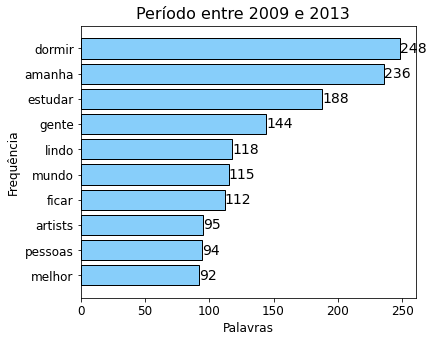

In [758]:
plot_barra_nlp(x_nlp_2009_2013, y_nlp_2009_2013, 'lightskyblue', 'Período entre 2009 e 2013')

Quais foram os artistas mais ouvidos segundo o *bot* do Last.fm?

In [759]:
# Agrupando pelos artistas e somar a frequência em que aparecem
lastfm_2009_2013 = lastfm_2009_2013.groupby(['artistas']).sum()
lastfm_2009_2013 = lastfm_2009_2013.sort_values(by='contagem', ascending=False)
lastfm_2009_2013 = lastfm_2009_2013.reset_index()

In [760]:
# Função para plotar os histogramas dos artistas mais ouvidos
def plot_barra_artistas(x, y, cor, titulo):
    fig, axs = plt.subplots(1, figsize=(8, 5))
    axs.bar(x, y, color=cor, edgecolor='black')

    # Centraliza e mostra o valor das barras
    for index, value in enumerate(y):
        plt.text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=14)

    # Rotação dos valores do eixo x
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Títulos dos eixos x e y
    plt.xlabel('Artistas', fontsize=12)
    plt.ylabel('Quantidade de músicas tocadas por artista', fontsize=12)

    # Título do gráfico
    fig.suptitle(titulo, y = 0.9, fontsize=16, ha='center', va='baseline')

    plt.show()
    
x_lastfm_2009_2013 = lastfm_2009_2013['artistas'][0:10]
y_lastfm_2009_2013 = lastfm_2009_2013['contagem'][0:10]

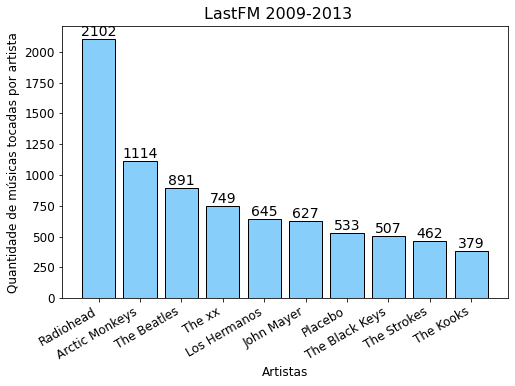

In [761]:
plot_barra_artistas(x_lastfm_2009_2013, y_lastfm_2009_2013, 'lightskyblue', 'LastFM 2009-2013')

#### AED: Período de 2013 a 2019

Para esse período percebemos que o ano de 2013 e 2014 foram os anos com maior número de *tweets*, a partir de 2015, a postagem de *tweets* cai para muito mais da metade, chegando em 2019 com o total de 43 tweets no ano.

In [762]:
# Número de tweets por ano
df_2013_2019['year'] = df_2013_2019['time'].dt.year
tweets_2013_2019 = df_2013_2019['year'].value_counts()
tweets_2013_2019 = pd.DataFrame(tweets_2013_2019)
tweets_2013_2019.reset_index().sort_values(by='index', ascending=True)

,index,year
1,2013,1082
0,2014,1258
5,2015,213
2,2016,376
3,2017,367
4,2018,236
6,2019,43


In [763]:
# Quanto eu twittei nesses 7 anos?
tweets_2013_2019['year'].sum()

3575

##### Quais foram as palavras mais recorrentes nesse período?

In [764]:
x_nlp_2013_2019 = nlp_2013_2019['index'][0:10]
y_nlp_2013_2019 = nlp_2013_2019['tweet'][0:10]

##### Visualização das palavras mais recorrentes entre 2013 e 2019

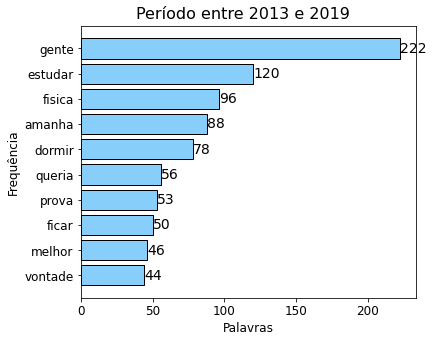

In [765]:
plot_barra_nlp(x_nlp_2013_2019, y_nlp_2013_2019, 'lightskyblue', 'Período entre 2013 e 2019')

##### Quais foram os artistas mais ouvidos segundo o *bot* do Last.fm?

In [766]:
# Agrupar pelos artistas e somar a frequência em que aparecem
lastfm_2013_2019 = lastfm_2013_2019.groupby(['artistas']).sum()
lastfm_2013_2019 = lastfm_2013_2019.sort_values(by='contagem', ascending=False)
lastfm_2013_2019 = lastfm_2013_2019.reset_index()

In [767]:
x_lastfm_2013_2019 = lastfm_2013_2019['artistas'][0:10]
y_lastfm_2013_2019 = lastfm_2013_2019['contagem'][0:10]

##### Visualização dos artistas mais recorrentes entre 2013 e 2019

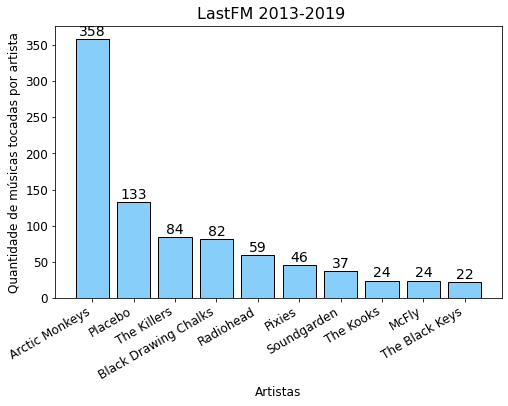

In [768]:
plot_barra_artistas(x_lastfm_2013_2019, y_lastfm_2013_2019, 'lightskyblue', 'LastFM 2013-2019')

##### Quais foram as categorias e canais mais visualizados no YouTube entre 2014 e 2019?

In [769]:
# transformando a coluna de 'time' para ano
df_yt['year'] = df_yt['time'].dt.year

#selecionando somente o período de 2014-2019
yt_2014_2019 = df_yt.loc[(df_yt['year'] >= 2014) & (df_yt['year'] <= 2019)]

In [771]:
# Função para plotar os gráficos de barras verticais das categorias e canais mais vistos
def plot_barra_youtube(x, y, cor, titulo, titulo_x, fonte_x):
    fig, axs = plt.subplots(1, figsize=(8, 8))
    axs.bar(x, y, color=cor, edgecolor='black')

    # Centraliza e mostra o valor das barras
    for index, value in enumerate(y):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

    # Rotação dos valores do eixo x
    plt.xticks(rotation=30, ha='right', fontsize=fonte_x)
    plt.yticks(fontsize=12)

    # Títulos dos eixos x e y
    plt.xlabel(titulo_x, fontsize=12)
    plt.ylabel('Quantidade de acessos', fontsize=12)

    # Título do gráfico
    fig.suptitle(titulo, y = 0.9, fontsize=12, ha='center', va='baseline')

    plt.show()

In [773]:
# Função para plotar os gráficos de barra horizontais dos titulos mais vistos
def plot_barrah_youtube(x, y, cor, titulo, fonte_x):
    fig, axs = plt.subplots(1, figsize=(8, 5))
    axs.barh(x, y, color=cor, edgecolor='black')

    # Centraliza e mostra o valor das barras
    for index, value in enumerate(y):
        plt.text(value + 0.1, index, str(value), ha='left', va='center', fontsize=14)

    # Rotação dos valores do eixo x
    plt.xticks(fontsize=fonte_x)
    plt.yticks(fontsize=12)

    # Títulos dos eixos x e y
    plt.xlabel('Títulos', fontsize=12)
    plt.ylabel('Quantidade de acessos', fontsize=12)

    # Título do gráfico
    fig.suptitle(titulo, y = 0.9, fontsize=20, ha='center', va='baseline')

    plt.gca().invert_yaxis()

In [774]:
categorias_2014_2019 = yt_2014_2019['category'].value_counts()
canais_2014_2019 = yt_2014_2019['channelName'].value_counts()
titulos_2014_2019 = yt_2014_2019['title'].value_counts()

categorias_2014_2019 = pd.DataFrame({'categoria':categorias_2014_2019.index, 'contagem':categorias_2014_2019.values})
canais_2014_2019 = pd.DataFrame({'canal':canais_2014_2019.index, 'contagem':canais_2014_2019.values})
titulos_2014_2019 = pd.DataFrame({'titulo':titulos_2014_2019.index, 'contagem':titulos_2014_2019.values})

In [775]:
x_categ_2014_2019 = categorias_2014_2019['categoria'][0:10]
y_categ_2014_2019 = categorias_2014_2019['contagem'][0:10]

x_canais_2014_2019 = canais_2014_2019['canal'][0:10]
y_canais_2014_2019 = canais_2014_2019['contagem'][0:10]

x_titulos_2014_2019 = titulos_2014_2019['titulo'][0:10]
y_titulos_2014_2019 = titulos_2014_2019['contagem'][0:10]

##### Quais foram os títulos mais visualizados no YouTube entre 2014 e 2019?

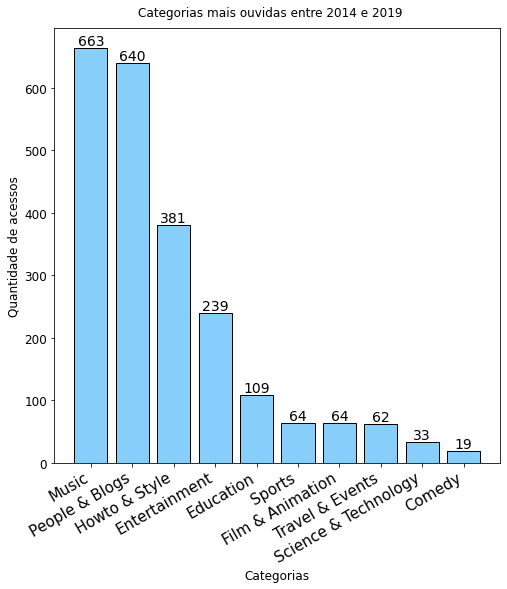

In [776]:
plot_barra_youtube(x_categ_2014_2019, y_categ_2014_2019, 'lightskyblue', 'Categorias mais ouvidas entre 2014 e 2019', 'Categorias', 15)

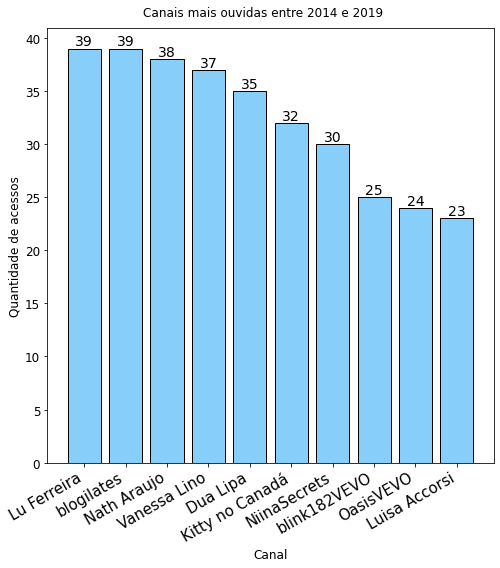

In [777]:
plot_barra_youtube(x_canais_2014_2019, y_canais_2014_2019, 'lightskyblue', 'Canais mais ouvidas entre 2014 e 2019', 'Canal', 15)

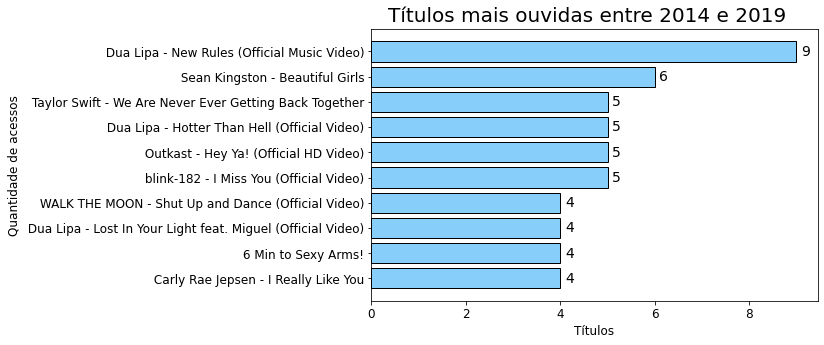

In [778]:
plot_barrah_youtube(x_titulos_2014_2019, y_titulos_2014_2019, 'lightskyblue', 'Títulos mais ouvidas entre 2014 e 2019', 12)

#### AED: Período de 2020 a 2021

Quando comparamos com outros períodos, percebemos que esse foi o período com menor número de *tweets* postados, em relação aos outros 10 anos, com o total de 79 *tweets*.

In [779]:
# Número de tweets por ano
df_2020_2021['year'] = df_2020_2021['time'].dt.year
tweets_2020_2021 = df_2020_2021['year'].value_counts()
tweets_2020_2021 = pd.DataFrame(tweets_2020_2021)
tweets_2020_2021.reset_index().sort_values(by='index', ascending=True)

,index,year
0,2020,54
1,2021,25


In [780]:
# Quanto eu twittei nesses 2 anos?
tweets_2020_2021['year'].sum()

79

##### Quais foram as categorias e canais mais visualizados no YouTube entre 2020 e 2021?

In [782]:
#selecionando somente o período de 2014-2019
yt_2020_2021 = df_yt.loc[(df_yt['year'] >= 2020) & (df_yt['year'] <= 2021)]

categorias_2020_2021 = yt_2020_2021['category'].value_counts()
canais_2020_2021 = yt_2020_2021['channelName'].value_counts()
titulos_2020_2021 = yt_2020_2021['title'].value_counts()

categorias_2020_2021 = pd.DataFrame({'categoria':categorias_2020_2021.index, 'contagem':categorias_2020_2021.values})
canais_2020_2021 = pd.DataFrame({'canal':canais_2020_2021.index, 'contagem':canais_2020_2021.values})
titulos_2020_2021 = pd.DataFrame({'titulo':titulos_2020_2021.index, 'contagem':titulos_2020_2021.values})

In [783]:
x_categ_2020_2021 = categorias_2020_2021['categoria'][0:10]
y_categ_2020_2021 = categorias_2020_2021['contagem'][0:10]

x_canais_2020_2021 = canais_2020_2021['canal'][0:10]
y_canais_2020_2021 = canais_2020_2021['contagem'][0:10]

x_titulos_2020_2021 = titulos_2020_2021['titulo'][0:10]
y_titulos_2020_2021 = titulos_2020_2021['contagem'][0:10]

##### Quais foram as categorias  mais visualizadas no YouTube entre 2020 e 2021?

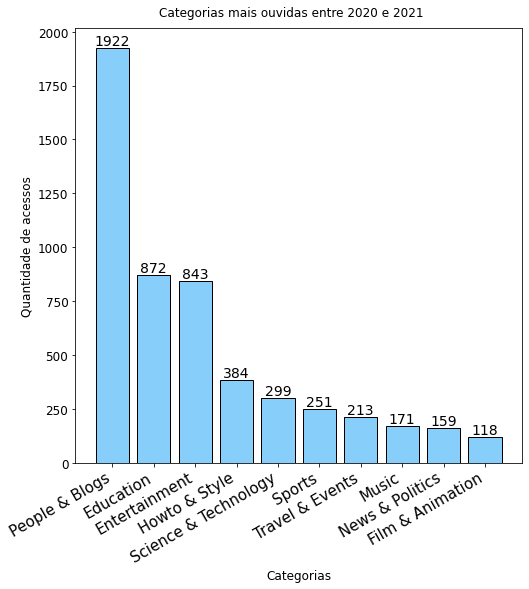

In [784]:
plot_barra_youtube(x_categ_2020_2021, y_categ_2020_2021, 'lightskyblue', 'Categorias mais ouvidas entre 2020 e 2021', 'Categorias', 15)

##### Quais foram os canais mais visualizados no YouTube entre 2020 e 2021?

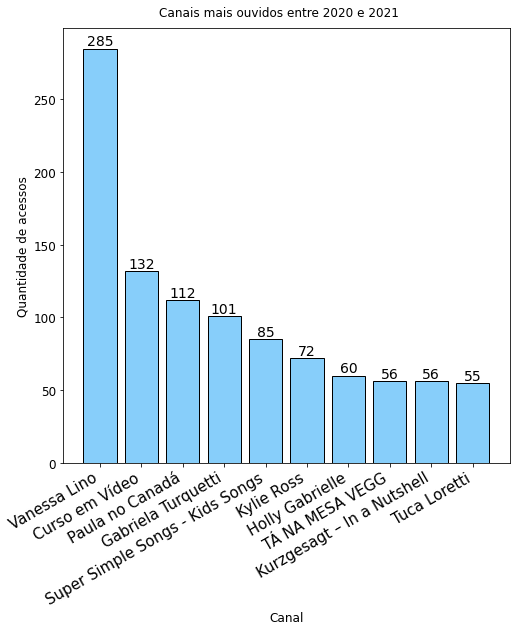

In [787]:
plot_barra_youtube(x_canais_2020_2021, y_canais_2020_2021, 'lightskyblue', 'Canais mais ouvidos entre 2020 e 2021', 'Canal', 15)

##### Quais foram os títulos mais visualizados no YouTube entre 2020 e 2021?

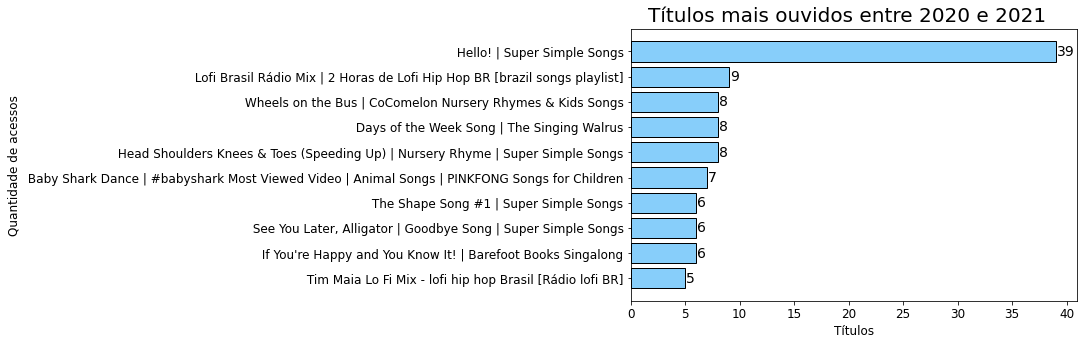

In [788]:
plot_barrah_youtube(x_titulos_2020_2021, y_titulos_2020_2021, 'lightskyblue', 'Títulos mais ouvidos entre 2020 e 2021', 12)

##### Quais foram os artistas mais ouvidos no Spotify entre 2020 e 2021?

In [789]:
# Contar a frequência em que os artistas aparecem e ordená-los em ordem decrescente
spotify_freq = df_sptfy['artistName'].value_counts().sort_values(ascending=False)
spotify_freq = pd.DataFrame({'artistas':spotify_freq.index, 'contagem':spotify_freq.values})


x_spotify = spotify_freq['artistas'][0:10]
y_spotify = spotify_freq['contagem'][0:10]

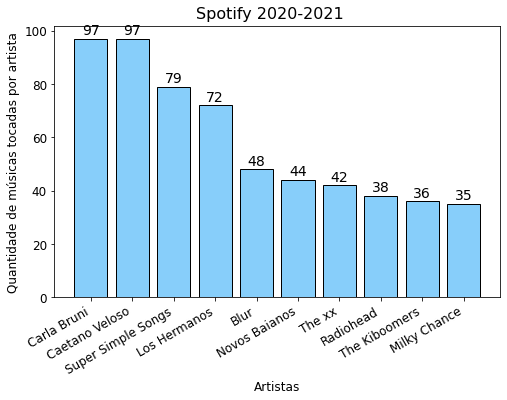

In [790]:
plot_barra_artistas(x_spotify, y_spotify, 'lightskyblue', 'Spotify 2020-2021')